In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn
from sklearn.pipeline import make_union, make_pipeline

from IPython.display import display

%matplotlib inline

In [17]:
train = pd.read_csv('titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('titanic/test.csv', index_col='PassengerId')

In [18]:
print(train.shape)
print(test.shape)

(891, 11)
(418, 10)


За титлите използвам кода от лекциите.

In [55]:
def extract_titles(data_in):
    data = data_in.copy()
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
    data.loc[data.Title == 'Mlle', 'Title'] = 'Miss'
    data.loc[data.Title == 'Mme', 'Title']  = 'Mrs'
    data.loc[data.Title == 'Ms', 'Title']   = 'Miss'

    rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir']
    data.Title = data.Title.replace(rare_titles, 'Rare')
    return data

За възрастите също.

In [54]:
def fill_ages_by_title(data_in):
    data = data_in.copy()
    age_by_title = data.groupby('Title').Age.mean()
    data.loc[data.Age.isnull() & (data.Title == 'Mr'), 'Age'] = age_by_title['Mr']
    data.loc[data.Age.isnull() & (data.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
    data.loc[data.Age.isnull() & (data.Title == 'Miss'), 'Age'] = age_by_title['Miss']
    data.loc[data.Age.isnull() & (data.Title == 'Master'), 'Age'] = age_by_title['Master']
    data.loc[data.Age.isnull() & (data.Title == 'Rare'), 'Age'] = age_by_title['Rare']
    return data

Запълвам embarked с S, както на лекцията.

In [56]:
def fill_embarked(data_in):
    data = data_in.copy()
    data.Embarked = data.Embarked.fillna('S')
    return data

In [57]:
def fill_fare(data_in):
    data = data_in.copy()
    data.Fare = data.Fare.fillna(data.Fare.mean())
    return data

След малко ровене в интернет установих, че първата буква от кабината означава палубата. Тъй като палубите са на различни нива в кораба, това може да окаже влияние върху крайния резултат. Където няма въведена кабина пиша N.

In [79]:
def add_decks(data_in):
    data = data_in.copy()
    data["deck"] = data.Cabin.str[0]
    data["deck"] = data.deck.fillna("N")
    return data

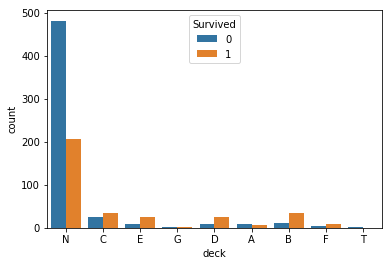

In [63]:
train_with_deck = add_decks(train)
sns.countplot('deck', hue='Survived', data=train_with_deck);

Повечето информация за кабината липсва. Разпределението на оцелелите е силно наклонено към неоцелели при липсващите палуби, докато във всички останали случаи броя на оцелелите е по-голям. Изглежда ако не си от палуба N, C, A, G шанса ти да оцелееш се вдига.

Резултата малко се подобрява като се разбие размера на семейството на малко и голямо семейство.

In [59]:
def bin_family(data_in):
    data = data_in.copy()
    family_size = data['Parch'] + data['SibSp'] + 1
    data['family_size_one'] = family_size == 1
    data['family_size_small'] = ((2 <= family_size) & (family_size <= 4))
    data['family_size_big'] = 5 <= family_size
    return data

Голямо влияние върху резултата оказа разделянето на вързастта. След известно натъкмяване избрах [0, 18, 36, 48, 60, 81] за кофи

In [60]:
def bin_age(data_in):
    data = data_in.copy()
    data["Age"] = pd.cut(data.Age, bins=[0, 18, 36, 48, 60, 81], labels=[0, 1, 2, 3, 4])
    age_dummied = pd.get_dummies(data["Age"], prefix="Age")
    data.drop("Age", axis=1, inplace=True)
    data = pd.concat([data, age_dummied], axis=1)
    return data

Извличам буквите от началото на билета като фийчър.

Не знам какво точно означават те, но реших да пробвам дали ще окажат влияние върху резултата.

In [70]:
def add_ticket_code(data_in):
    data = data_in.copy()
    data["ticket_code"] = data.Ticket.str.replace("[0-9]|[/., ]", "")
    data.ticket_code = data.ticket_code.fillna("NONE")
    return data

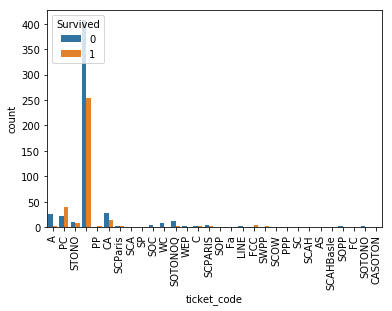

In [74]:
train_with_ticket = add_ticket_code(train)
ax = sns.countplot('ticket_code', hue='Survived', data=train_with_ticket);
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Ако билета ти има код А, CA, SOTONOQ, имаш голям шанс да умреш. Докато ако има код PC шанса да оцелееш е по-голям. За повечето примери няма стойност, но все пак кода може да помогне.

In [252]:
def engineer_data(data_in):
    data = fill_embarked(data_in)
    data = fill_fare(data)
    data = extract_titles(data)
    data = add_decks(data)
    data = add_ticket_code(data)
    data = fill_ages_by_title(data)
    data = bin_family(data)
    data = bin_age(data)
    data = data.drop(["Cabin", "Ticket", "Name", 'SibSp', 'Parch'], axis=1)
    data = pd.get_dummies(data)
    return data

Използвам pd.get_dummies за one hot encode-ване на нужните фийчъри.

In [119]:
train_engineered.head()

,Survived,Pclass,Sex,Fare,Embarked,Title,deck,ticket_code,family_size_one,family_size_small,family_size_big,Age_0,Age_1,Age_2,Age_3,Age_4
PassengerId,,,,,,,,,,,,,,,,
1,0,3,male,7.2500,S,Mr,N,A,False,True,False,0,1,0,0,0
2,1,1,female,71.2833,C,Mrs,C,PC,False,True,False,0,0,1,0,0
3,1,3,female,7.9250,S,Miss,N,STONO,True,False,False,0,1,0,0,0
4,1,1,female,53.1000,S,Mrs,C,,False,True,False,0,1,0,0,0
5,0,3,male,8.0500,S,Mr,N,,True,False,False,0,1,0,0,0


In [271]:
train_engineered = engineer_data(train)
test_engineered = engineer_data(test)

In [272]:
X = train_engineered.drop("Survived", axis=1)
y = train_engineered["Survived"]

In [351]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=0)
print(cross_val_score(model_rf, X, y, cv=StratifiedKFold()))

[ 0.76094276  0.82154882  0.78787879]


Да видим какви са важностите на различните фийчъри според random forest.

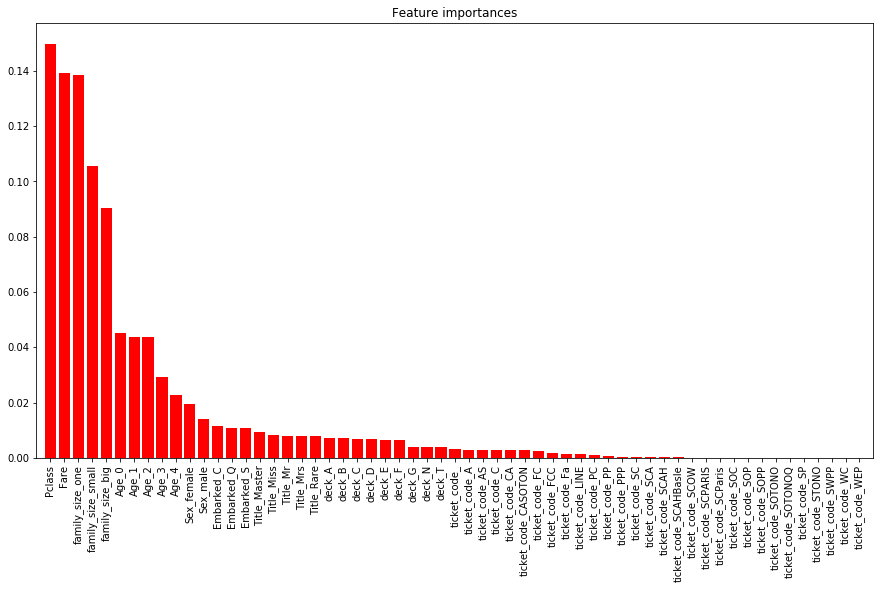

In [288]:
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", align="center")
plt.xticks(range(len(indices)), X_train.columns, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Както се очаква Pclass и fare имат най-голям принос. Палубите и билетите все пак имат ненулев принос.

Да пуснем grid search.

In [340]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

forest_grid = {
                 'max_depth' : [2, 5, 10, 15, 20],
                 'n_estimators': [10, 20, 30, 40 ,50],
                 'min_samples_split': [2, 5, 10, 20]
                 }
rf = RandomForestClassifier(random_state=0)
grid = GridSearchCV(rf,
                           scoring='accuracy',
                           param_grid=forest_grid,
                           cv=StratifiedKFold(),
                           return_train_score=True)

grid.fit(X, y)

results_df = pd.DataFrame(grid.cv_results_)
results_df[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,params
91,1,0.840629,"{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 20}"
93,2,0.839506,"{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 40}"
71,3,0.833895,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 20}"
94,4,0.832772,"{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}"
92,4,0.832772,"{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 30}"


In [352]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=0, 
                                  max_depth=20, min_samples_split=10, n_estimators=20)
print(cross_val_score(model_rf, X, y, cv=StratifiedKFold()))

[ 0.82491582  0.86868687  0.82828283]


Резултатите се подобриха. Да пробваме и с SVC.

Пробвам и с SVC

In [323]:
from sklearn.svm import SVC
model_svc = SVC()
print(cross_val_score(model_svc, X, y, cv=StratifiedKFold()))

[ 0.75084175  0.8013468   0.77441077]


In [355]:
svc_grid = {
                 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,100000],
                 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000 ]
                 }
svc = SVC()
grid = GridSearchCV(svc,
                           scoring='accuracy',
                           param_grid=svc_grid,
                           cv=StratifiedKFold(),
                           return_train_score=True)

grid.fit(X, y)

results_df = pd.DataFrame(grid.cv_results_)
results_df[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,params
2,1,0.829405,"{'C': 100000, 'gamma': 1e-05}"
1,2,0.811448,"{'C': 100, 'gamma': 0.01}"
3,3,0.787879,"{'C': 100000, 'gamma': 0.01}"
0,4,0.689113,"{'C': 100, 'gamma': 1e-05}"


In [357]:
from sklearn.svm import SVC
model_svc = SVC(C=100000, gamma=0.00001)
print(cross_val_score(model_svc, X, y, cv=StratifiedKFold()))

[ 0.81818182  0.82491582  0.83838384]


Справя се по-зле. Да видим и логистична регресия.

In [358]:
from sklearn.linear_model import LogisticRegression
model_log_reg = LogisticRegression()
print(cross_val_score(model_log_reg, X, y, cv=StratifiedKFold()))

[ 0.81818182  0.82154882  0.84848485]


In [360]:
log_reg_grid = {
                 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 100]
                 }
log_reg = LogisticRegression()
grid = GridSearchCV(log_reg,
                           scoring='accuracy',
                           param_grid=log_reg_grid,
                           cv=StratifiedKFold(),
                           return_train_score=True)

grid.fit(X, y)

results_df = pd.DataFrame(grid.cv_results_)
results_df[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,params
3,1,0.829405,{'C': 1}
4,2,0.826038,{'C': 10}
5,2,0.826038,{'C': 100}
6,2,0.826038,{'C': 100}
2,5,0.822671,{'C': 0.1}


Най-добре се представя RandomForest. Все пак ще събмитна и с трите модела.

In [269]:
np.setdiff1d(test_engineered.columns,X.columns )

array(['Title_Dona', 'ticket_code_AQ', 'ticket_code_LP',
       'ticket_code_STONOQ'], dtype=object)

In [289]:
np.setdiff1d(X.columns, test_engineered.columns )

array(['deck_T', 'ticket_code_AS', 'ticket_code_CASOTON', 'ticket_code_Fa',
       'ticket_code_LINE', 'ticket_code_PPP', 'ticket_code_SCAHBasle',
       'ticket_code_SCOW', 'ticket_code_SOP', 'ticket_code_SP',
       'ticket_code_SWPP'], dtype=object)

Виждам, че има разлика в колоните за трейн и за тест затова първо добавям в train и в test колоните които липсват, със стойности 0.

In [363]:
col_to_add_test = np.setdiff1d(X.columns, test_engineered.columns)
col_to_add_train = np.setdiff1d(test_engineered.columns, X.columns)
submit_x_train = X.copy()
submit_test= test_engineered.copy()
for col in col_to_add_train:
    submit_x_train[col] = 0
    
for col in col_to_add_test:
    submit_test[col] = 0
    
submit_x_train = submit_x_train.reindex_axis(sorted(submit_x_train.columns), axis=1)
submit_test = submit_test.reindex_axis(sorted(submit_test.columns), axis=1)

model = RandomForestClassifier(random_state=0, 
                                  max_depth=20, min_samples_split=10, n_estimators=20)
model.fit(submit_x_train, y)

predictions = model.predict(submit_test)

frame = pd.DataFrame({
    'PassengerId': pd.read_csv('titanic/test.csv').PassengerId,
    'Survived': predictions.astype(int)
})
frame = frame.set_index('PassengerId')
frame.to_csv('~/Desktop/predictions_titanic.csv')
frame.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


Резултата в kaggle е 

<img src="img/result_titanic.png">

Резултатите с другите два модела бяха значително по-слаби (от рода на 0.77....)